# Why initialization is important in neural networks?

- toc: false 
- badges: true
- categories: [neural-network]
- image: images/normal-distributions.png

Today, when you build a deep neural network with standard layers and activation functions, you usually don't encounter much problems in training process. But, this wasn't always so. Exploding/vanishing gradients and numerical instability issues were common. We don't often have such problems anymore, mostly because ReLU has become the default non-linearity and modern neural network frameworks uses the right initialization schemes under the hood. But, why is initialization important?

We can consider a neural network as a collection learnable parameters that are initialized randomly and updated with gradient descent. In theory, this must find the optimal parameters, no matter the initial values. However, since the floating point representations used in computers have a finite range and precision, picking wrong initial values may cause out-of-range numerical values and cripple training process. 

OK, how about constraining all the initial values to a specific range, such as [-1, 1] or [-0.1, 0.1]? Would it solve the problem? Unfortunately, it may not. In modern deep neural networks, the input goes through many layers, each changing incoming data in a specific way. Therefore, the changes accumulate through the network and eventually may cause the values grow too large or too small. To solve this problem for all networks with arbitrary number of layers, we use proven initialization schemes that keep the variance of data and gradients unchanged through neural network as much as possible.

## How does the properties of a distribution changes through various transformations?

In [1]:
#collapse-hide
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn

# Set seaborn aesthetic parameters to defaults
seaborn.set()
seaborn.set_style('whitegrid')
seaborn.set_palette("dark")

import numpy as np
import torch
np.random.seed(42)

def plot_distributions(*arrays, bins=None, fig_width=12, fig_height=4, xlim=None):
    n = len(arrays)
    fig = plt.figure(figsize=(fig_width, fig_height*n))
    for i, x in enumerate(arrays):
        ax = fig.add_subplot(n, 1, i+1)
        seaborn.distplot(x, bins=bins)
        ax.set_title(stats_desc(x))
        ax.set_xlim(xlim)

In [2]:
def plot_distribution(x, bins=None, fig_width=12, fig_height=4, xlim=None):
    fig = plt.figure(figsize=(fig_width, fig_height))
    seaborn.distplot(x, bins=bins)
    plt.title(name + ' ' + stats_desc(x))
    plt.xlim(xlim)

In [3]:
def stats_desc(x):
    return f"μ: {x.mean():+.3f}  σ: {x.std():.3f}"

Let's assume that the input is from a uniform distribution between [-1, 1].

$x \sim U[-1, 1]$

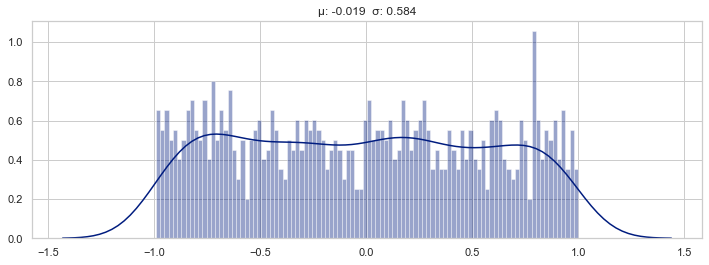

In [4]:
n = 1000
x = np.random.uniform(-1, 1, n)
plot_distributions(x, bins=100)

### Summation

The sum of two independent uniform distribution is a distribution with

$\quad \mu= \mu_1 + \mu_2 \quad \sigma^2=\sigma_1^2 + \sigma_2^2$

Added a uniform dist. μ: +5.070  σ: 2.920


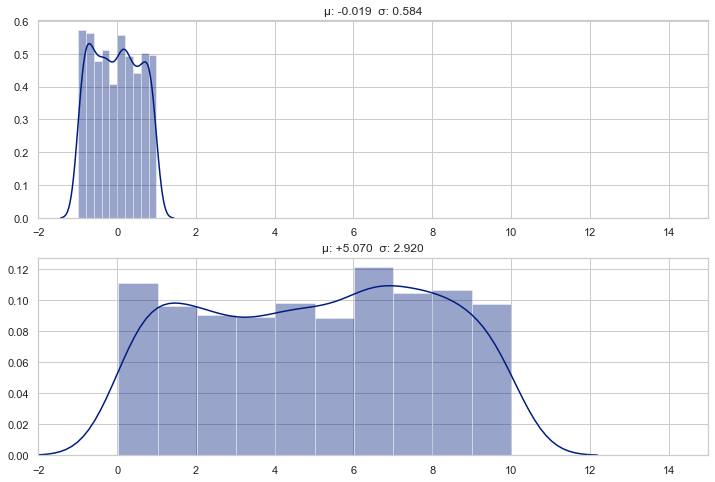

In [5]:
y = np.random.uniform(0, 10, n)
z = x + y

print(f"Added a uniform dist. {stats_desc(y)}")

plot_distributions(x, y, xlim=(-2, 15), fig_width=12)

### Scale and shift

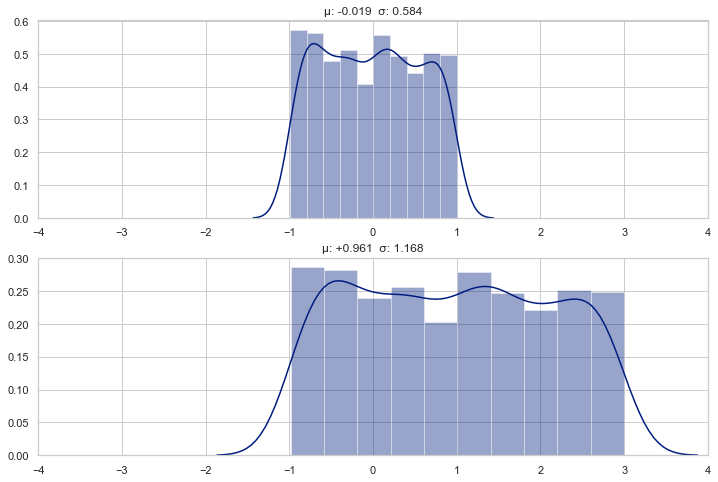

In [6]:
y = 2 * x + 1

plot_distributions(x, y, xlim=(-4, 4))

### Affine transformation

A linear layer (or fully connected layer) with weights, $W \sim U[-c, c]$ , approximately transforms a uniform distribution $x \sim U[-1, 1]$ to a normal distribution $y \sim \mathcal N(\mu, \sigma)$ 

$ \mu = 0 \quad $ $\sigma^2 = n_{in} ~ \sigma_{input}^2 ~ \sigma_{w}^2\$

$n_{in}$: size of input, also denoted as, $\text{fan}_{in}$

Let's initialize weights with $W \sim U[-1, 1]$.

Weight μ: +0.001  σ: 0.577
Bias   μ: +0.008  σ: 0.566


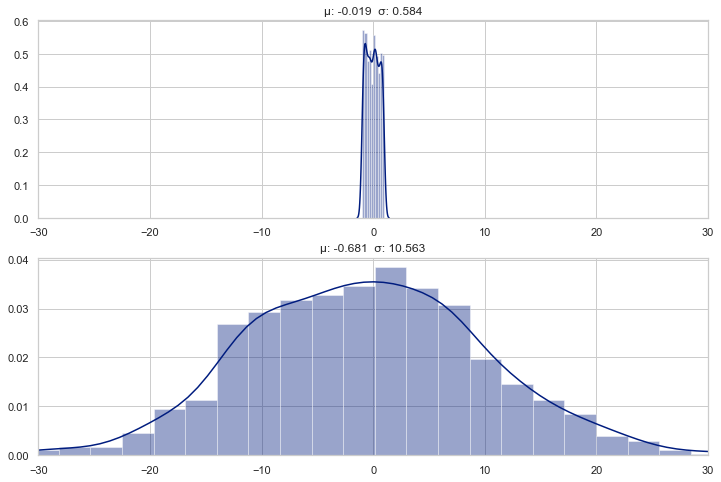

In [7]:
W = np.random.uniform(-1, 1, size=(n, n))
bias = np.random.uniform(-1, 1, size=n)

print(f"Weight {stats_desc(W)}")
print(f"Bias   {stats_desc(bias)}")

y = x @ W + bias
plot_distributions(x, y, xlim=(-30, 30))

The variance increased dramatically even after one layer. 

Let's try smaller weights with $W \sim U[-0.1, 0.1]$

Weight μ: -0.000  σ: 0.058
Bias   μ: +0.002  σ: 0.057


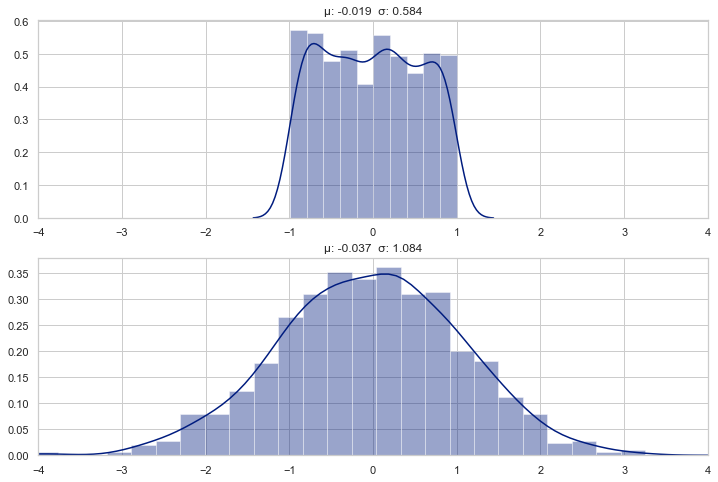

In [8]:
W = np.random.uniform(-.1, .1, size=(n, n))
bias = np.random.uniform(-.1, .1, size=n)

print(f"Weight {stats_desc(W)}")
print(f"Bias   {stats_desc(bias)}")

y = x @ W + bias
plot_distributions(x, y, xlim=(-4, 4))

This looks better, the variance goes up slightly. Let's see how it performs with multiple layers with various sizes.

In [9]:
class Affine:
    def __init__(self, dim_in, dim_out, weight_bound=0.1, bias_bound=0.1):
        self.W = np.random.uniform(-weight_bound, weight_bound, size=(dim_in, dim_out))
        self.b = np.random.uniform(-bias_bound, bias_bound, size=dim_out)

    def __call__(self, x):
        return x @ self.W + self.b

In [10]:
layers = [
    Affine(x.shape[-1], 256),
    Affine(256, 512),
    Affine(512, 1024),
    Affine(1024, 1024),
    Affine(1024, 1024),
    Affine(1024, 1024),
]

In [11]:
activations = []
y = x
for layer in layers:
    y = layer(y)
    activations.append(y)

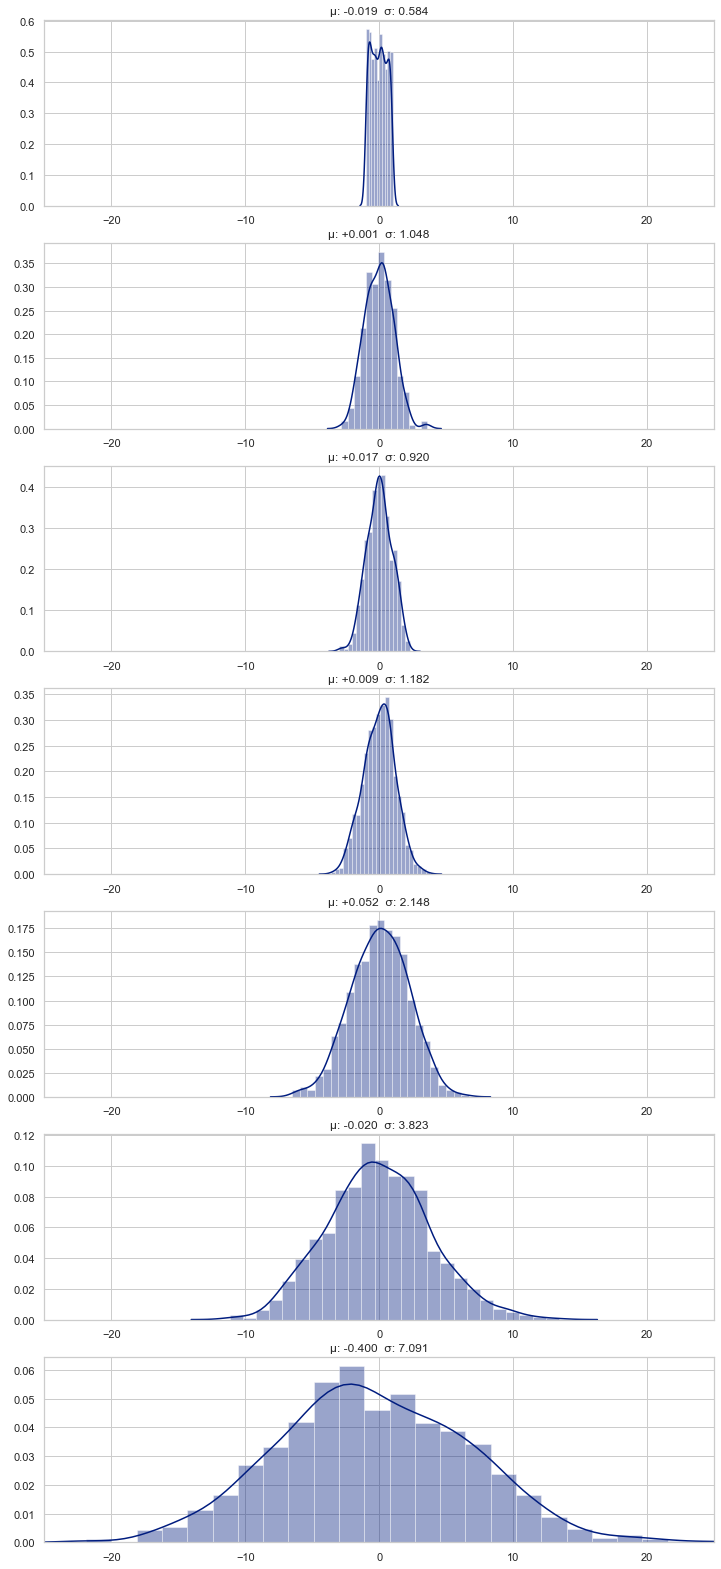

In [12]:
plot_distributions(x, *activations, xlim=(-25, 25))

The variance keeps increasing after each layer and at the end it is much larger than the beginning's. 

## Solution

We need to keep variance of data and gradients unchanged through the network as much as possible. 

In forward pass,

$$ \sigma^2 = n_{in} ~ \sigma_{input}^2 ~ \sigma_{w}^2 $$

To keep variance unchanged, we want to have

$$ n_{in} ~ \sigma_w^2 = 1 \quad \sigma_{w}^2 = \frac{1}{n_{in}} $$

A similar tranformation happens in backward pass when gradients flow in reverse direction. 

$$ \sigma_\text{grad before layer}^2 = n_{out}~\sigma_{w}^2~\sigma_{\text{grad after layer}}^2 $$

Again, we want to have

$$ n_{out} ~ \sigma_w^2 = 1 \quad \sigma_{w}^2 = \frac{1}{n_{out}} $$

Unless $n_{in}=n_{out}$, we cannot satisfy both constraints. Therefore, we do our best.

$$
\frac{1}{2} (n_{in} + n_{out}) \sigma_{w}^2 = 1 \\ \sigma_w^2 = \frac{2}{n_{in} + n_{out}}
$$


Remember the variance of a uniform distribution with U[a, b]

$$ \sigma^2 = \frac{(b-a)^2}{12} $$

$$ \sigma_{w}^2 = \frac{(2c)^2}{12} = \frac{c^2}{3} $$

Hence,

$$ \frac{c^2}{3} = \frac{2}{n_{in} + n_{out}} \quad c = \sqrt{\frac{6}{n_{in} + n_{out}}} $$

This is known as Xavier initialization.




Now, let's initialize the weights according to Xavier initialization, see how it affects variance.

In [13]:
class XavierAffine:
    def __init__(self, dim_in, dim_out):
        weight_bound = np.sqrt(6/(dim_in + dim_out))
        bias_bound = np.sqrt(2/(dim_in + dim_out))
        
        self.W = np.random.uniform(-weight_bound, weight_bound, size=(dim_in, dim_out))
        self.b = np.random.uniform(-bias_bound, bias_bound, size=dim_out)

    def __call__(self, x):
        return x @ self.W + self.b

In [14]:
xav_layers = [
    XavierAffine(x.shape[-1], 256),
    XavierAffine(256, 512),
    XavierAffine(512, 1024),
    XavierAffine(1024, 1024),
    XavierAffine(1024, 1024),
    XavierAffine(1024, 1024),
]

In [15]:
activations = []
y = x
for layer in xav_layers:
    y = layer(y)
    activations.append(y)

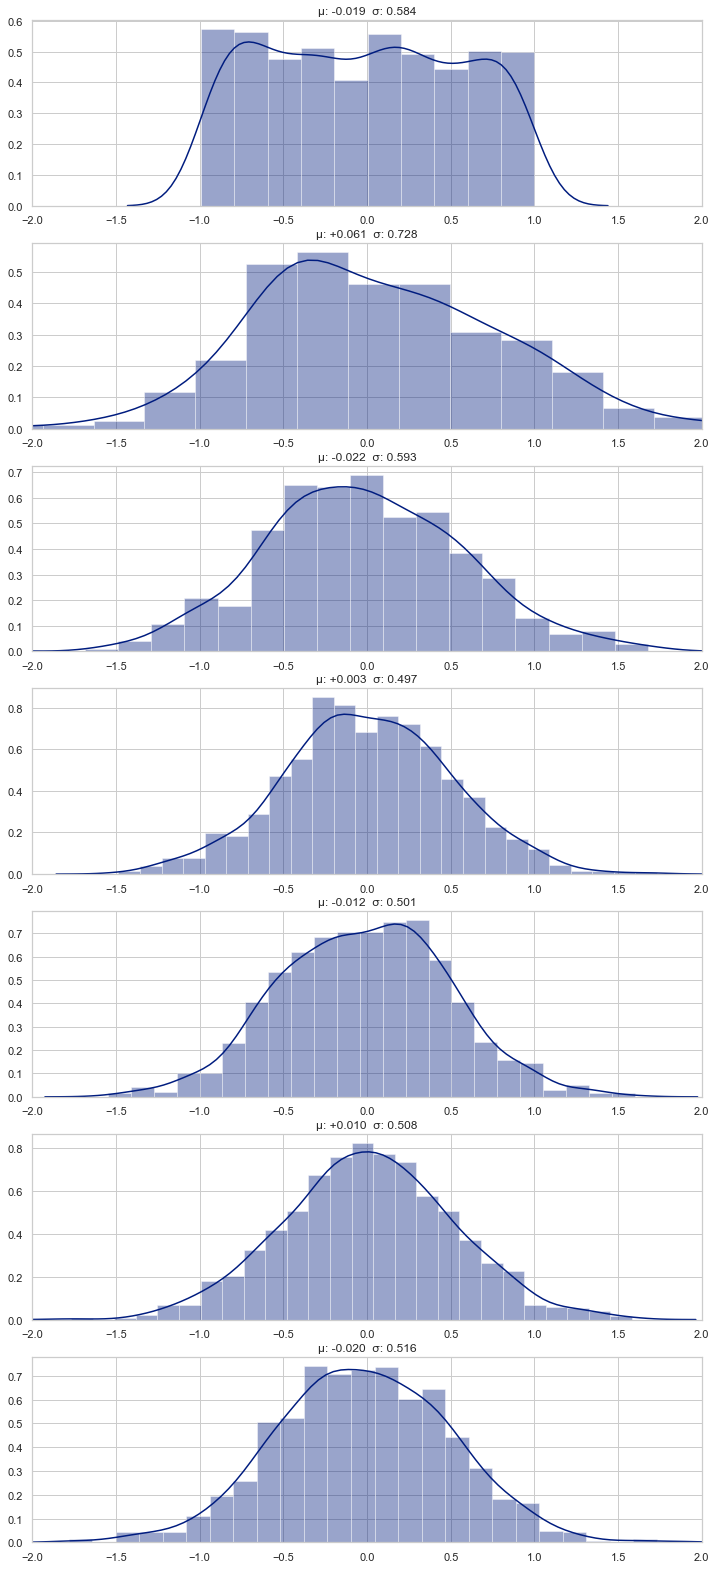

In [16]:
plot_distributions(x, *activations, xlim=(-2, 2))

As it's seen, with Xaiver initialization, the variance does not vary much through the layers. 

## References

1. http://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization